In [1]:
import numpy as np
import time
import scipy
from scipy.linalg import hadamard, hilbert

In [2]:
from numba import njit

@njit
def fwht(a):
    '''
    реализацию преобразования Уолша-Адамара (Fast Walsh-Hadamard Transform, FWHT) для одномерного массива a. 
    '''
    b = a.copy()
    
    # Начальное значение шага h равно 1.
    h = 1
    
    while h < len(b):
        # Выполнение FWHT.
        # Проходим через массив с шагом в 2*h, что соответствует текущему размеру блока.
        for i in range(0, len(b), h * 2):
            # Внутри каждого блока размером 2*h проводим парные операции над элементами.
            for j in range(i, i + h):
                # Сохраняем текущие значения элементов.
                x = b[j]
                y = b[j + h]
                # Обновляем элементы в соответствии с правилами FWHT.
                b[j] = x + y      # Сумма элементов.
                b[j + h] = x - y  # Разность элементов.
        
        # Удваиваем шаг для следующей итерации, что соответствует увеличению размера блока вдвое.
        h *= 2
    
    return b


    
def matvec_Theta(vec, s, n):
    np.random.seed(911)
    d = np.random.choice([-1, 1], size=(n,))
    idx = np.random.choice(range(0, n), size=(s,), replace=True)
    return fwht(scipy.sparse.diags(d)@vec)[idx] #sxn
    
n = int(1024*1024)
vec = np.random.rand(n)
s = 100  

%time matvec_Theta(vec, s, n)
1==1

CPU times: total: 1.3 s
Wall time: 2 s


True

In [3]:
def Algorithm_21(A, b, m, s): 
    """A is square matrix nxn, b is vector of size n.
    m is number of iterations, s - row size of sketch matrix Theta sxn.
    Returns V_{m+1}, H_m that satisfies Arnoldi-like decomposition"""
    n = A.shape[0]
    R = np.zeros((m+1,m+1))
    
    wi_start = b
    pi_start = matvec_Theta(wi_start, s, n)
    rii_start = np.linalg.norm(pi_start)
    si_start = pi_start/rii_start
    
    Si_prev = si_start.reshape(-1,1)
    vi_prev = wi_start/rii_start
    Vi_prev = vi_prev.reshape(-1,1)

    for i in range(1, m+1):
        wi_cur = A@vi_prev
        pi_cur = matvec_Theta(wi_cur, s, n)
        ri_cur = Si_prev.T@pi_cur
        R[:i, i] = ri_cur
        si_cur = pi_cur - Si_prev@ri_cur
        rii_cur = np.linalg.norm(si_cur) + 1e-12
        si_cur = si_cur/rii_cur
        
        Si_cur = np.c_[Si_prev, si_cur]
        vi_cur = (wi_cur - Vi_prev@ri_cur)/rii_cur
        Vi_cur = np.c_[Vi_prev, vi_cur]

        Si_prev = Si_cur
        vi_prev = vi_cur
        Vi_prev = Vi_cur
        
    Hm = R[:, 1:]
    return Si_prev, Vi_prev, Hm

# Арнольди

In [7]:
def Arnoldi(A, b, m):
    """Compute a basis of the (n + 1)-Krylov subspace of the matrix A.

    This is the space spanned by the vectors {b, Ab, ..., A^n b}.

    Parameters
    ----------
    A : array_like
        An m × m array.
    b : array_like
        Initial vector (length m).
    n : int
        One less than the dimension of the Krylov subspace, or equivalently the *degree* of the Krylov space. Must be >= 1.
    
    Returns
    -------
    Q : numpy.array
        An m x (n + 1) array, where the columns are an orthonormal basis of the Krylov subspace.
    h : numpy.array
        An (n + 1) x n array. A on basis Q. It is upper Hessenberg.
    """
    eps = 1e-12
    h = np.zeros((n + 1, n))
    Q = np.zeros((A.shape[0], n + 1))
    # Normalize the input vector
    Q[:, 0] = b / np.linalg.norm(b, 2)  # Use it as the first Krylov vector
    for k in range(1, n + 1):
        v = np.dot(A, Q[:, k - 1])  # Generate a new candidate vector
        for j in range(k):  # Subtract the projections on previous vectors
            h[j, k - 1] = np.dot(Q[:, j].conj(), v)
            v = v - h[j, k - 1] * Q[:, j]
        h[k, k - 1] = np.linalg.norm(v, 2)
        if h[k, k - 1] > eps:  # Add the produced vector to the list, unless
            Q[:, k] = v / h[k, k - 1]
        else:  # If that happens, stop iterating.
            return Q, h, np.linalg.norm(b)
    return Q, h, np.linalg.norm(b)

# Тут пока не смотреть

In [16]:
import numpy as np
from scipy.sparse import isspmatrix
from scipy.linalg import norm
from scipy.sparse.linalg import LinearOperator, cg
import math

def basis_bg_fast(n, A, b, m, thetagenfun=None, lssolver=None, lowprecision=False):
    if isinstance(A, (np.ndarray, np.generic)) or isspmatrix(A):
        # Convert matrix A into a function that performs matrix-vector multiplication
        A_func = lambda x: A @ x
    elif not callable(A):
        raise ValueError("A must be a square matrix or a function handle")
    
    # Assign default values to unspecified parameters
    if thetagenfun is None:
        k = min(n, int(2 * m * math.log(n) / math.log(m)))
        k = min(n, 2 * m)
        thetagenfun = lambda: SRHT(n, k)
        Theta = thetagenfun()
    else:
        Theta = thetagenfun
        k = Theta(np.zeros(n)).shape[0]
    
    if lssolver is None:
        lssolver = '3reorth'
    
    # Normalize right-hand side
    n2b = norm(b)
    rhs = b / n2b
    
    # Allocate space for Krylov basis matrix
    Q = np.zeros((n, m), dtype='double')
    
    # Randomized GMRES
    
    # Allocate space for small matrices and vectors
    R = np.zeros((m, m))
    S = np.zeros((k, m))
    P = np.zeros((k, m))
    
    # Perform first iteration
    s = Theta(rhs)
    p = s
    P[:, 0] = p
    r = np.array([norm(s)] + [0] * (m - 1))
    s = s / r[0]
    q = rhs / r[0]
    
    for initer in range(1, m):
        Q[:, initer - 1] = q
        S[:, initer - 1] = s
        R[:, initer - 1] = r
        
        # Perform RGS iteration
        w = A_func(q)
        
        p = Theta(w)
        P[:, initer] = p
        
        r[:initer] = leastsquares(S[:, :initer], p, lssolver)
        
        if lowprecision:
            q = w.astype('float32') - Q[:, :initer] @ r[:initer].astype('float32')
            s = Theta(q.astype('double'))
        else:
            q = w - Q[:, :initer] @ r[:initer]
            s = p - S[:, :initer] @ r[:initer]
        
        r[initer] = norm(s)
        q = q / r[initer]
        s = s / r[initer]
    
    H = R[:, 1:]
    
    return Q, H, R

def leastsquares(S, p, lssolver):
    if lssolver in ['3reorth', '5reorth', '20reorth']:
        j = int(lssolver[:-6])
        
        r = S.T @ p
        p -= S @ r
        
        for _ in range(j - 1):
            dr = S.T @ p
            p -= S @ dr
            r += dr
    else:
        Stemp = S[:, :S.shape[1]]
        rtemp, _ = cg(lambda x: Stemp.T @ (Stemp @ x), Stemp.T @ p, tol=1.0e-14, maxiter=20)
        r = np.concatenate([rtemp, np.zeros(S.shape[1] - len(rtemp))])
    
    return r

def SRHT(n, k):
    D = np.random.choice([-1, 1], n)
    N = 2 ** int(math.ceil(math.log(n) / math.log(2)))
    perm = np.random.permutation(N)[:k]
    
    def select(t, ind):
        return t[ind]
    
    def Theta(t):
        return (1 / math.sqrt(k)) * select(myfwht(D * t), perm)
    
    return Theta

def myfwht(a):
    h = 1
    n = len(a)
    N = 2 ** int(math.ceil(math.log(n) / math.log(2)))
    z = np.zeros(N)
    z[:n] = a
    
    while h < N:
        for i in range(0, N, 2 * h):
            for j in range(i, i + h):
                x = z[j]
                y = z[j + h]
                z[j] = x + y
                z[j + h] = x - y
        h *= 2
    
    return z

# Графики

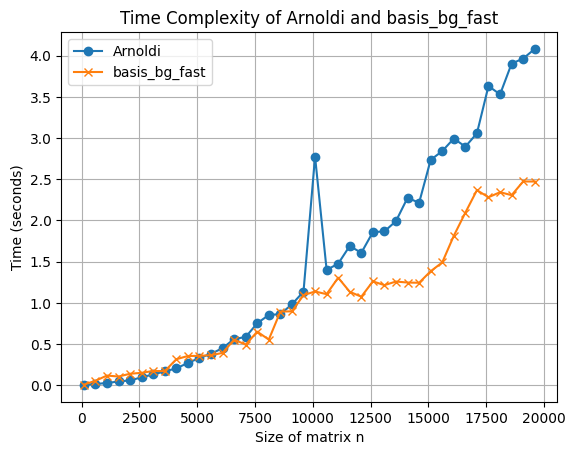

In [32]:
import numpy as np
from scipy.sparse import random as sparse_random
from scipy.linalg import norm
import matplotlib.pyplot as plt
import time


# Функция для измерения времени работы каждой из функций
def measure_time(n_values, m):
    arnoldi_times = []
    basis_bg_fast_times = []

    for n in n_values:
        # Генерация случайной разреженной матрицы A размером n*n и вектора b
        A = sparse_random(n, n, density=0.01, format='csr', dtype=np.float64).toarray()
        b = np.random.rand(n)

        # Замер времени для Arnoldi
        start_time = time.time()
        Arnoldi(A, b, m)
        arnoldi_times.append(time.time() - start_time)

        # Замер времени для basis_bg_fast
        start_time = time.time()
        basis_bg_fast(n, A, b, m)
        basis_bg_fast_times.append(time.time() - start_time)

    return arnoldi_times, basis_bg_fast_times

# Диапазон значений n для тестирования
n_values = range(100, 20_000, 500)
m = 10  # Произвольно выбранное значение для m

# Измерение времени работы функций
arnoldi_times, basis_bg_fast_times = measure_time(n_values, m)

# Построение графика зависимости времени от n
plt.plot(n_values, arnoldi_times, label='Arnoldi', marker='o')
plt.plot(n_values, basis_bg_fast_times, label='basis_bg_fast', marker='x')
plt.xlabel('Size of matrix n')
plt.ylabel('Time (seconds)')
plt.title('Time Complexity of Arnoldi and basis_bg_fast')
plt.legend()
plt.grid(True)
plt.show()
